## Import Libraries

In [3]:
'''basics'''
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('..', 'src')))
sys.setrecursionlimit(20500)
import pandas as pd
import pickle5 as pickle
import numpy as np

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

'''features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB


'''Metrics/Evaluation'''
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.constants import ROOT
from sklearn_hierarchical_classification.metrics import h_fbeta_score, multi_labeled
from sklearn.pipeline import Pipeline


import warnings
warnings.filterwarnings('ignore')


## Import data and holdout data for prediction

In [4]:
df = pd.read_json('../data/processed/encoded_labels/main_landscapes_all.json')
df.columns

Index(['PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'forest', 'tundra',
       'conserved_areas', 'freshwater', 'grassland', 'desert', 'marine',
       'wetlands', 'human_altered_areas', 'no tag', 'category_1', 'category_2',
       'category_3', 'labels'],
      dtype='object')

In [5]:
df_labels = df.drop(['PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'category_1', 'category_2', 'category_3',
       'labels'], axis=1)
counts = []
categories = list(df_labels.columns.values)
for i in categories:
    counts.append((i, df_labels[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_inputs'])
df_stats

,category,number_of_inputs
0,forest,120
1,tundra,3
2,conserved_areas,153
3,freshwater,58
4,grassland,48
5,desert,15
6,marine,85
7,wetlands,39
8,human_altered_areas,222
9,no tag,516


Text(0.5, 0, 'category')

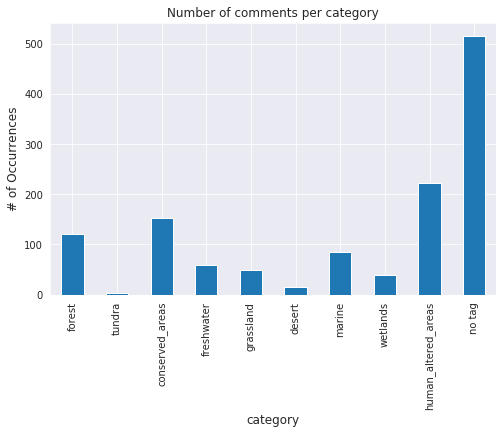

In [6]:
df_stats.plot(x='category', y='number_of_inputs', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

## How many comments have multi labels

Text(0.5, 0, '# of categories')

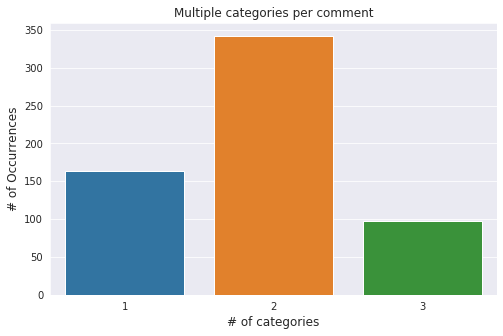

In [7]:
rowsums = df.iloc[:,4:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

## The distribution of the number of words in input texts

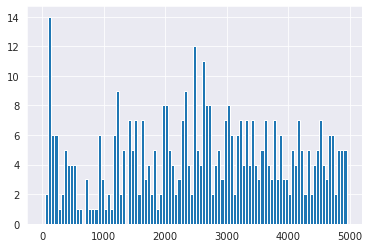

In [8]:
lens = df.all_text_clean.str.len()
lens.hist(bins = np.arange(0,5000,50))

## Holding out 5 rows from the original dataframe for prediction at the end

In [9]:
df_holdout = df.iloc[:5]

df = df.iloc[5:]

In [10]:
df.columns

Index(['PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'forest', 'tundra',
       'conserved_areas', 'freshwater', 'grassland', 'desert', 'marine',
       'wetlands', 'human_altered_areas', 'no tag', 'category_1', 'category_2',
       'category_3', 'labels'],
      dtype='object')

##  Features engineering

In [11]:
categories = ['forest', 'tundra',
       'conserved_areas', 'freshwater', 'grassland', 'desert', 'marine',
       'wetlands', 'human_altered_areas', 'no tag']


#Creating the features (tf-idf weights) for the processed text
texts = df['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)

#Turning the labels into numbers
y = pd.DataFrame(df, columns = categories)
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)


## Train multiple ML models / OneVsRest multi-label strategy

In [12]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
#Creating a dict of the models
model_dict = {
              'Stochastic Gradient Descent' : OneVsRestClassifier(SGDClassifier(random_state=3, loss='log'), n_jobs=1),
              'Random Forest': OneVsRestClassifier(RandomForestClassifier(random_state=3), n_jobs=1),
              'Decsision Tree': OneVsRestClassifier(DecisionTreeClassifier(random_state=3), n_jobs=1),
              'AdaBoost': OneVsRestClassifier(AdaBoostClassifier(random_state=3), n_jobs=1),
              'Gaussian Naive Bayes': OneVsRestClassifier(GaussianNB(), n_jobs=1),
              'K Nearest Neighbor': OneVsRestClassifier(KNeighborsClassifier(), n_jobs=1)}


#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True,  
                                                    random_state = 3)
y_train = y_train.dropna(axis=1)
#Function to get the scores for each model in a df
def model_score_df(model_dict, X_train, X_test, y_train, y_test):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df


def printTable(myDict, colList=None, sep='\uFFFA'):
    """ Pretty print a list of dictionaries (myDict) as a dynamically sized table.
   If column names (colList) aren't specified, they will show in random order.
   sep: row separator. Ex: sep='\n' on Linux. Default: dummy to not split line.
   Author: Thierry Husson - Use it as you want but don't blame me.
   """
    if not colList: colList = list(myDict[0].keys() if myDict else [])
    myList = [colList] # 1st row = header
    for item in myDict: myList.append([str(item[col] or '') for col in colList])
    colSize = [max(map(len,(sep.join(col)).split(sep))) for col in zip(*myList)]
    formatStr = ' | '.join(["{{:<{}}}".format(i) for i in colSize])
    line = formatStr.replace(' | ','-+-').format(*['-' * i for i in colSize])
    item=myList.pop(0); lineDone=False
    while myList:
        if all(not i for i in item):
            item=myList.pop(0)
            if line and (sep!='\uFFFA' or not lineDone): print(line); lineDone=True
        row = [i.split(sep,1) for i in item]
        print(formatStr.format(*[i[0] for i in row]))
        item = [i[1] if len(i)>1 else '' for i in row]
        

from tabulate import tabulate        
lis = []
for category in categories:
    dic = {}
    dff = model_score_df(model_dict, X_train, X_test, y_train[category], y_test[category])
    # Using DataFrame.insert() to add a column
    dic['Category'] = category
    dic['#Inputs'] = df_stats.number_of_inputs[df_stats['category'] == category]
    dic['Classifiers'] = '    \n '.join(dff.model_name.apply(str).tolist())
    dic['accuracy_score'] = '    \n '.join(dff.accuracy_score.apply(str).tolist()) 
    dic['precision_score'] = '   \n '.join(dff.precision_score.apply(str).tolist())
    dic['recall_score'] = '    \n '.join(dff.recall_score.apply(str).tolist())
    dic['f1_score'] = '    \n '.join(dff.f1_score.apply(str).tolist())
    lis.append(dic)
    
#headers = ['Category', 'Classifiers', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
#print(tabulate(lis, tablefmt='html'))
header = lis[0].keys()
rows =  [x.values() for x in lis]
#print (tabulate(rows, header, tablefmt='html'))


<table>
<thead>
<tr><th>Category           </th><th style="text-align: right;">  #Inputs</th><th>Classifiers  </th><th>accuracy_score  </th><th>precision_score  </th><th>recall_score  </th><th>f1_score  </th></tr>
</thead>
<tbody>
<tr><td>forest             </td><td style="text-align: right;">      120</td><td>Stochastic Gradient Descent    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Random Forest              </td><td>0.8055555555555556    
 0.8055555555555556    
 0.8222222222222222    
 0.7222222222222222    
 0.7944444444444444    
 0.8277777777777777                 </td><td>0.7319711538461539   
 0.7232142857142857   
 0.7625806451612904   
 0.6918160170447424   
 0.704045954045954   
 0.9088235294117647                  </td><td>0.7709247236357255    
 0.7193367257413581    
 0.6785400947534656    
 0.7685558869977189    
 0.6433584839445516    
 0.6219512195121951               </td><td>0.7462848858281986    
 0.7212266029470331    
 0.7031539888682746    
 0.6875000000000000    
 0.6607406652743111    
 0.6459166190748143           </td></tr>
<tr><td>tundra             </td><td style="text-align: right;">        3</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9944444444444445    
 0.9888888888888889                 </td><td>0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.49722222222222223   
 0.4972067039106145                  </td><td>0.5000000000000000    
 0.5000000000000000    
 0.5000000000000000    
 0.5000000000000000    
 0.5000000000000000    
 0.4972067039106145               </td><td>0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4986072423398329    
 0.4972067039106145           </td></tr>
<tr><td>conserved_areas    </td><td style="text-align: right;">      153</td><td>K Nearest Neighbor    
 Stochastic Gradient Descent    
 Gaussian Naive Bayes    
 AdaBoost    
 Decsision Tree    
 Random Forest              </td><td>0.850000000000000    
 0.8388888888888889    
 0.8277777777777777    
 0.8333333333333334    
 0.8222222222222222    
 0.8277777777777777                 </td><td>0.7962962962962963   
 0.7813846382409746   
 0.7738669238187078   
 0.7736742424242424   
 0.7593582887700534   
 0.7695035460992907                  </td><td>0.8008021390374331    
 0.8165106951871658    
 0.8322192513368984    
 0.7897727272727273    
 0.7593582887700534    
 0.7476604278074866               </td><td>0.7984991085865916    
 0.795382384069617    
 0.7915966386554623    
 0.7809863724853991    
 0.7593582887700534    
 0.7572963333478318           </td></tr>
<tr><td>freshwater         </td><td style="text-align: right;">       58</td><td>AdaBoost    
 Stochastic Gradient Descent    
 K Nearest Neighbor    
 Decsision Tree    
 Gaussian Naive Bayes    
 Random Forest              </td><td>0.9111111111111111    
 0.8944444444444445    
 0.8944444444444445    
 0.8722222222222222    
 0.6888888888888889    
 0.9000000000000000                 </td><td>0.7976190476190477   
 0.7394715111478117   
 0.7394715111478117   
 0.6473975126669738   
 0.5917065390749601   
 0.949438202247191                  </td><td>0.6875000000000000    
 0.5906250000000000    
 0.5906250000000000    
 0.6000000000000000    
 0.7156250000000000    
 0.5500000000000000               </td><td>0.725609756097561    
 0.6196196196196196    
 0.6196196196196196    
 0.616346955796497    
 0.572228823629265    
 0.5642818719741797           </td></tr>
<tr><td>grassland          </td><td style="text-align: right;">       48</td><td>Decsision Tree    
 K Nearest Neighbor    
 Gaussian Naive Bayes    
 AdaBoost    
 Stochastic Gradient Descent    
 Random Forest              </td><td>0.9111111111111111    
 0.9277777777777778    
 0.8111111111111111    
 0.9111111111111111    
 0.9222222222222223    
 0.9222222222222223                 </td><td>0.6901893287435455   
 0.7685714285714286   
 0.5902777777777778   
 0.632183908045977   
 0.7134831460674158   
 0.7134831460674158                  </td><td>0.6901893287435455    
 0.601118760757315    
 0.7013769363166953    
 0.5593803786574871    
 0.5327022375215147    
 0.5327022375215147               </td><td>0.6901893287435455    
 0.6388331532643926    
 0.6051612903225807    
 0.5764705882352942    
 0.5421511627906976    
 0.5421511627906976           </td></tr>
<tr><td>desert             </td><td style="text-align: right;">       15</td><td>AdaBoost    
 K Nearest Neighbor    
 Decsision Tree    
 Stochastic Gradient Descent    
 Gaussian Naive Bayes    
 Random Forest              </td><td>0.9777777777777777    
 0.9777777777777777    
 0.9611111111111111    
 0.9722222222222222    
 0.8888888888888888    
 0.9777777777777777                 </td><td>0.7443181818181819   
 0.7443181818181819   
 0.6370767960363336   
 0.6581920903954802   
 0.5437500000000001   
 0.4888888888888889                  </td><td>0.7443181818181819    
 0.7443181818181819    
 0.7357954545454546    
 0.6193181818181819    
 0.6988636363636364    
 0.5000000000000000               </td><td>0.7443181818181819    
 0.7443181818181819    
 0.6717895285230528    
 0.6357749898826386    
 0.5535714285714286    
 0.4943820224719101           </td></tr>
<tr><td>marine             </td><td style="text-align: right;">       85</td><td>Stochastic Gradient Descent    
 AdaBoost    
 K Nearest Neighbor    
 Random Forest    
 Decsision Tree    
 Gaussian Naive Bayes              </td><td>0.8888888888888888    
 0.8777777777777778    
 0.8611111111111112    
 0.8833333333333333    
 0.7944444444444444    
 0.6833333333333333                 </td><td>0.7754168028767571   
 0.7448337825696316   
 0.7083333333333333   
 0.8591954022988506   
 0.5966666666666667   
 0.5937001594896332                  </td><td>0.7174193548387097    
 0.7109677419354838    
 0.7012903225806452    
 0.5967741935483871    
 0.6122580645161291    
 0.6819354838709677               </td><td>0.7410817031070195    
 0.7258377180836333    
 0.7047050331386573    
 0.6293754289636239    
 0.6029806259314456    
 0.5808652314228522           </td></tr>
<tr><td>wetlands           </td><td style="text-align: right;">       39</td><td>Stochastic Gradient Descent    
 Gaussian Naive Bayes    
 Random Forest    
 K Nearest Neighbor    
 AdaBoost    
 Decsision Tree              </td><td>0.9388888888888889    
 0.8222222222222222    
 0.9333333333333333    
 0.9333333333333333    
 0.9111111111111111    
 0.9000000000000000                 </td><td>0.9691011235955056   
 0.5856524427952999   
 0.9664804469273742   
 0.9664804469273742   
 0.5657142857142857   
 0.5367464905037159                  </td><td>0.5769230769230769    
 0.6913864578535237    
 0.5384615384615384    
 0.5384615384615384    
 0.5264854905573468    
 0.5204974666052511               </td><td>0.6173913043478261    
 0.6012184990307394    
 0.5540875309661437    
 0.5540875309661437    
 0.5321637426900585    
 0.5235294117647059           </td></tr>
<tr><td>human_altered_areas</td><td style="text-align: right;">      222</td><td>Stochastic Gradient Descent    
 K Nearest Neighbor    
 Random Forest    
 AdaBoost    
 Decsision Tree    
 Gaussian Naive Bayes              </td><td>0.7944444444444444    
 0.7500000000000000    
 0.7444444444444445    
 0.7000000000000000    
 0.6611111111111111    
 0.6277777777777778                 </td><td>0.7809806034482758   
 0.7341718485019786   
 0.7534097108565194   
 0.6772282683565229   
 0.636762360446571   
 0.6402439024390244                  </td><td>0.7755250297186633    
 0.7188614449874521    
 0.6840575881653679    
 0.669924712719588    
 0.635913353586052    
 0.6488574824990094               </td><td>0.7779925997533251    
 0.7242553191489363    
 0.6924676868221662    
 0.6726831896551724    
 0.636315458249147    
 0.6251748251748251           </td></tr>
<tr><td>no tag             </td><td style="text-align: right;">      516</td><td>Stochastic Gradient Descent    
 Gaussian Naive Bayes    
 AdaBoost    
 Random Forest    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.8611111111111112    
 0.7500000000000000    
 0.8500000000000000    
 0.8611111111111112    
 0.8444444444444444    
 0.7833333333333333                 </td><td>0.7259615384615384   
 0.6437252685132844   
 0.6897590361445782   
 0.7382352941176471   
 0.6727272727272727   
 0.5900000000000000                  </td><td>0.7047930283224401    
 0.7461873638344226    
 0.6067538126361656    
 0.5980392156862745    
 0.6034858387799564    
 0.5980392156862745               </td><td>0.7144488863506567    
 0.653475935828877    
 0.6284119581007721    
 0.6234624717596853    
 0.6226415094339623    
 0.5935383011985409           </td></tr>
</tbody>
</table>